# Part 2: Deep Reinforcement Learning

In this part of the assignment you will work on a more challenging control task in the [Lunar Lander environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/). The state space is continuous and we will employ Deep Q-Learning (DQN) using a deep neural network to handle generalizing between states. 

**Learning objectives.** You will:
1. Implement the Deep Q-learning (DQN) algorithm with epsilon greedy action selection
2. Apply DQN to train an agent on a challenging control task with a large (continuous) state space
3. Evaluate the learning curve of average episodic return over training

While it is possible to complete this assignment using CPU compute, it may be slow. To accelerate your training, consider using GPU resources such as `CUDA` through the CS department cluster. Alternatives include Google colab or local GPU resources for those running on machines with GPU support.

If you were able to run `pip install "gymnasium[all]"` in Part 1 then you may not need to install any additional dependencies to work with the Lunar Lander environment. However, if you were only able to install the base `gymnasium` then you may need to complete the additional installations of `swig` and `box2d` below. The first two commands use `pip` for the package manager, the third uses `conda` if you are using the Anaconda package manager.

In [1]:
pip install swig

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install box2d-py

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
conda install -c conda-forge swig box2d-py

Channels:
 - conda-forge
 - defaults
 - nvidia
 - pytorch
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /usr/pkg/miniconda-23.9.0

  added / updated specs:
    - box2d-py
    - swig


The following NEW packages will be INSTALLED:

  archspec           conda-forge/noarch::archspec-0.2.3-pyhd8ed1ab_0 
  box2d-py           conda-forge/linux-64::box2d-py-2.3.8-py311hfdbb021_9 
  libgcc             conda-forge/linux-64::libgcc-14.2.0-h77fa898_1 
  libstdcxx          conda-forge/linux-64::libstdcxx-14.2.0-hc0a3c3a_1 
  libzlib            conda-forge/linux-64::libzlib-1.2.13-h4ab18f5_6 
  python_abi         conda-forge/linux-64::python_abi-3.11-2_cp311 
  swig               conda-forge/linux-64::swig-4.2.1-hc9a1274_0 

The following packages will be UPDATED:

  ca-certificates    pkgs/main::ca-certificates-2023.08.22~ --> conda-forge::ca-certificates-2024.8.30-hbcca054_0 
  certifi            pkgs/main/linux-64::certifi-2023.7.22~ --> conda-forge/no

You can check that the installation was successful by running the following code. The code attempts to import the gymnasium module, create a [Lunar Lander environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/), and then execute random actions in the environment. 

The environment is set to `render_mode="human"`, meaning you should see a visualization of the environment with the agent taking random actions. Be aware that the visualization can be unstable on some platforms -- in particular, if your Python Kernel crashes after closing the visualization, that will not prevent you from completing the assignment (but is a good indication that you should save your learned Q tables/networks before rendering a visualization so that you don't lose any work).

In [13]:
import gymnasium as gym

# Initialise the environment
env = gym.make("LunarLander-v3", render_mode="human")

# Reset the environment to generate the first observation
observation, info = env.reset()
for _ in range(200):
    # this is where you would insert your policy
    action = env.action_space.sample()

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action)

    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env.reset()

env.close()

error: XDG_RUNTIME_DIR not set in the environment.


## Task 1

As we will be implementing DQN, your first task is to define a deep neural network architecture to use to estimate the Q function during training. You should familiarize yourself with the [Lunar Lander environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/) documentation to understand the state/observation space, action space, and reward function.

In [14]:
import torch
import torch.nn as nn

class NeuralNet(nn.Module):
    """
    Neural network to approximate the Q-function in DQN.
    """
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  
        self.fc3 = nn.Linear(hidden_dim, output_dim)  

    def forward(self, x):
        """
        Forward pass through the network.
        :param x: Input state (observation)
        :return: Q-values for all actions
        """
        x = torch.relu(self.fc1(x)) 
        x = torch.relu(self.fc2(x))  
        x = self.fc3(x)  
        return x



## Task 2

Your next task is to define the `LunarLanderAgent` which should also implement the deep Q-learning (DQN) algorithm. The structure of the class is left up to you: While you are welcome to adopt a similar structure of `__init__`, `action_select`, and `update` as in Part 1, you are also free to change the structure as you see fit. 

The implementation will be more challenging than in the Part 1 tabular case. You may wish to review 11/25's lecture in particular for a discussion of the implementation. A few tips and reminders:
1. You should use a main Q-network, the weights of which you will regular update, and a frozen target Q-network used to predict the future predictive target, the weights of which you will periodically copy from the main Q-network. You should copy these weights only everal several thousand steps in the environment for stability. Both should share the same architecture you defined above and should be saved as instance variables of your agent, along with a PyTorch loss MSE loss function and optimizer.
2. You should use an experience replay buffer and employ batched updates to the weights of your Q-network. The easiest data structure to use for the experience replay buffer is probably the [Python collections deque](https://docs.python.org/3/library/collections.html#collections.deque). You probably want an experience replay buffer that is at least as large as 100,000 experiences, if not more.
3. You will likely need a lower learning rate such as `0.001` or `0.0005`. Also, you will want a good amount of exploration early on. If using `epsilon` decay, you should decay only very slowly, as you should expect to need thousands of episodes to learn a good policy.
4. While you are not required to use GPU training for Q-network operations, it will substantially accelerate training, and you are encouraged to do so. Make sure not to store all of the experiences in your entire experience replay buffer on the GPU. Instead, store those on CPU memory and only move batches on GPU before training. Otherwise you are likely to run out of memory during training.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque

class LunarLanderAgent:
    def __init__(self, state_dim, action_dim, device='cpu', replay_buffer_size=100000, batch_size=64, gamma=0.99, 
                 learning_rate=0.0005, epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.995, target_update_freq=1000):
        self.device = device
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update_freq = target_update_freq
        
        # Initialize Q-networks
        self.q_network = NeuralNet(state_dim, action_dim).to(self.device)
        self.target_q_network = NeuralNet(state_dim, action_dim).to(self.device)
        self.target_q_network.load_state_dict(self.q_network.state_dict())  # Copy weights
        self.target_q_network.eval()
        
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        
        self.replay_buffer = deque(maxlen=replay_buffer_size)
        self.steps = 0

    def action_select(self, state):
        """
        Select an action using epsilon-greedy policy.
        """
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)  # Random action
        state = torch.FloatTensor(state).to(self.device).unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            q_values = self.q_network(state)
        return torch.argmax(q_values, dim=1).item()  # Exploit best action

    def store_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))
        
    def update(self):
        """
        Perform a single training step on the Q-network.
        """
        if len(self.replay_buffer) < self.batch_size:
            return 

        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Compute Q-values for current states
        q_values = self.q_network(states).gather(1, actions).squeeze(1)
        
        # Compute target Q-values
        with torch.no_grad():
            next_q_values = self.target_q_network(next_states).max(1)[0]
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)
        
        # Compute loss
        loss = self.loss_fn(q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self.target_q_network.load_state_dict(self.q_network.state_dict())

I had to consult ChatGPT here in order to figure out syntax for computing q-values and target values for current states, as well as describing which Q-networks to initialize. Furthermore, I asked GPT to provide me with the most optimal parameters so that this would allow for early exploration while also converging at an efficient speed.

## Task 3

Train your DQN agent on the Lunar Lander environment. You should be able to learn a policy that achieves an average/expected episode return (cumulative reward) of approximately 200 or more -- **we will consider the training a success if the average/expected episode return converges to greater than 150**. To accomplish this you may need to experiment with several of the key hyperparameters for the learning agent. Note that the learning will likely be much more challenging and variable than in the Part 1 warmup task.

While you are not required, you are encouraged to print periodic evaluation information during training (for example, every 100 or so episodes you may wish to printout the average return of the last 100 episodes) in order to track progress.

Training will take quite some time on this environment: You should expect to need between **1 and 10 thousand episodes** of experience (You should use a small number between 100 and 1 thousand while prototyping your implementation, then several thousand for your final training). Even with GPU acceleration you should expect this to take **several minutes or as much as an hour** (for your final run over several thousand episodes). Partially for this reason, you are strongly encourage to **save your Q-network model parameters** after a substantial and long training run, to ensure you do not lose them. See the [PyTorch documentation on loading and saving model parameters](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

It is relatively common/likely on this lunar lander environment to get stuck in a local optimum where the agent learns to "hover" but not land. Landing correctly is difficult and crashing incurs a large negative reward, so sometimes the agent gets "stuck" in a policy of hovering in place without attempt to land. This results in an average return of around 0. If your agent is getting stuck like this, one recommendation is to modify the reward function by adding a per-timestep reward penalty during learning. You can do this very simply in the training loop by just reducing the reward as in `r = r - timestep_penalty` before passing the experience to your agent. A value for `timestep_penalty` between 0.1 and 0.5 may help to incentivize the agent not to "hover" but to actually attempt and learn how to land. 

In [64]:
import torch
import gymnasium as gym
import numpy as np
from matplotlib import pyplot as plt

def train_dqn_agent_with_recording():
    env = gym.make("LunarLander-v3")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    device = "cuda" if torch.cuda.is_available() else "cpu"
    agent = LunarLanderAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        device=device,
        replay_buffer_size=100000,
        batch_size=64,
        gamma=0.99,
        learning_rate=0.0005,
        epsilon_start=1.0,
        epsilon_end=0.1,
        epsilon_decay=0.995,
        target_update_freq=1000
    )

    num_episodes = 5000
    max_timesteps = 500
    timestep_penalty = 0.1
    model_save_path = "dqn_lunar_lander.pth"

    rewards_history = []  
    lengths_history = []  

    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        total_reward = 0
        episode_length = 0 
        done = False

        for t in range(max_timesteps):
            action = agent.action_select(state)  # greedy action selection
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            reward -= timestep_penalty
            total_reward += reward
            episode_length += 1  # timesteps for current episode

            agent.store_transition(state, action, reward, next_state, done)
            agent.update()

            if done:
                break
            state = next_state

        rewards_history.append(total_reward)
        lengths_history.append(episode_length)

        if episode % 100 == 0:
            print(f"Episode {episode}/{num_episodes}: Total Reward = {total_reward:.2f}, Epsilon = {agent.epsilon:.4f}")

    env.close()
    torch.save(agent.q_network.state_dict(), model_save_path)
    print("Training completed. Model saved at:", model_save_path)

    return rewards_history, lengths_history

if __name__ == "__main__":
    rewards_history, lengths_history = train_dqn_agent_with_recording()

Episode 100/5000: Total Reward = -138.21, Epsilon = 0.1000
Episode 200/5000: Total Reward = 22.20, Epsilon = 0.1000
Episode 300/5000: Total Reward = 17.12, Epsilon = 0.1000
Episode 400/5000: Total Reward = 139.65, Epsilon = 0.1000
Episode 500/5000: Total Reward = 232.79, Epsilon = 0.1000
Episode 600/5000: Total Reward = 208.91, Epsilon = 0.1000
Episode 700/5000: Total Reward = 228.49, Epsilon = 0.1000
Episode 800/5000: Total Reward = 267.98, Epsilon = 0.1000
Episode 900/5000: Total Reward = 236.75, Epsilon = 0.1000
Episode 1000/5000: Total Reward = -81.14, Epsilon = 0.1000
Episode 1100/5000: Total Reward = 210.14, Epsilon = 0.1000
Episode 1200/5000: Total Reward = 283.01, Epsilon = 0.1000
Episode 1300/5000: Total Reward = 227.78, Epsilon = 0.1000
Episode 1400/5000: Total Reward = 250.92, Epsilon = 0.1000
Episode 1500/5000: Total Reward = 278.39, Epsilon = 0.1000
Episode 1600/5000: Total Reward = 266.26, Epsilon = 0.1000
Episode 1700/5000: Total Reward = 237.91, Epsilon = 0.1000
Episode

I had to ask GPT to figure out how to transition from using a regular return queue for tabular learning to using a deque for DQN.

## Task 4

After training, you can use the `visualize_learning_curves` function below to create two plots: One of the moving average episode return over the course of training and another of the moving average episode length over the course of training. A `smoothing` parameter to the function determines how many episodes to average over. That is, the default of `smoothing=10` means that each point in the resulting figure is the average of ten episodes. This has the visual effect of *smoothing* out the appearance of the plot, which can make the overall trend easier to visualize even if individual episodes vary significantly.

Create visualizations of your learning curves. You should see improving performance on average episode return converging toward approximately 150 or above. The learning may be more variable than in Part 1, so you may wish to increase the `smoothing` parameter to `50` or even `100` to make it easier to visualize the average trend.

In [74]:
import numpy as np
from matplotlib import pyplot as plt

def visualize_learning_curves(rewards, lengths, smoothing=10):
    rewards = np.array(rewards)
    lengths = np.array(lengths)

    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    axs[0].plot(np.convolve(rewards, np.ones(smoothing), 'valid') / smoothing, label="Smoothed Returns")
    axs[0].set_title("Episode Returns", fontsize=20)
    axs[0].set_xlabel("Episode", fontsize=20)
    axs[0].set_ylabel("Return", fontsize=20)

    axs[1].plot(np.convolve(lengths, np.ones(smoothing), 'valid') / smoothing, label="Smoothed Episode Lengths")
    axs[1].set_title("Episode Lengths", fontsize=20)
    axs[1].set_xlabel("Episode", fontsize=20)
    axs[1].set_ylabel("Length", fontsize=20)

    plt.tight_layout()
    plt.show()

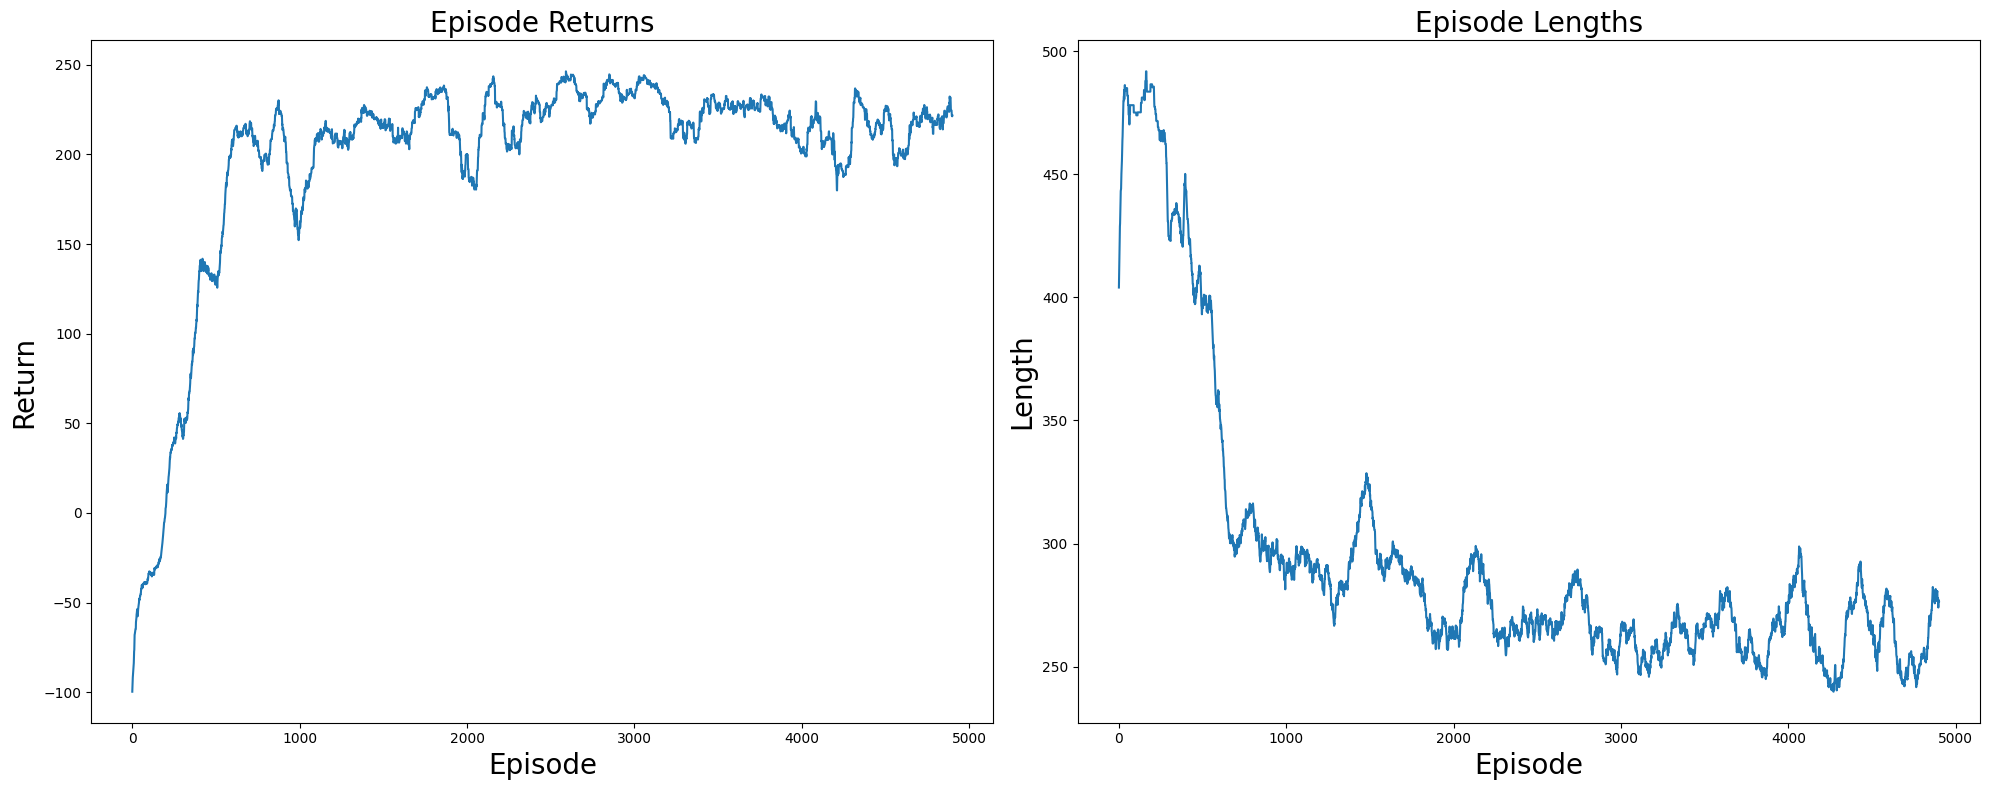

In [76]:
# todo: visualize learning curves
visualize_learning_curves(rewards_history, lengths_history, smoothing=100)


## Optional

The above evaluation of the learning curve was purely quantiative. While you are not required, you are invited and encouraged to qualitatively evaluate your learned policy/agent visually below. To do so, render the environment in `"human"` mode as shown below. This should render the visualization of the environment. Write a standard environment loop over several episodes (but far fewer than used for training, perhaps just 5 or so), and use the trained agent for action selection. For this evaluation purpose, you are welcome to set `epsilon` to a lower value or even 0, and you do not need to perform learning updates.

Again, be aware that the visualization can be unstable on some platforms -- in particular, if your Python Kernel crashes after closing the visualization, that will not prevent you from completing the assignment (but is a good indication that you should save your learned Q tables/networks before rendering a visualization so that you don't lose any work).

In [10]:
# Initialise the environment
env = gym.make("LunarLander-v3", render_mode="human")

# optional todo: environment loop to visualize learned policy